# Individual Project: Strava Archive Analysis
## Manipulation of the Dataset

In [1]:
# import the packages below to enable analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# read in the csv files containing the strava archive data
strava = pd.read_csv("activities.csv") 

# visualise the first five rows of the dataset
strava.head()

,Activity Date,Start Time,Activity Name,Activity Type,Commute,Activity Gear,Bike,Shoes,Elapsed Time,Moving Time,...,Average Heart Rate,Relative Effort,Perceived Relative Effort,Elevation Gain,Elevation High,Max Grade,Max Cadence,Average Cadence,Weather Condition,Weather Temperature
0,18-Apr-16,07:41:47,Ride_1,Ride,False,Ammaco Ethos,2792869.0,NaN,295.0,239,...,NaN,NaN,NaN,0.00,23.900000,5.4,NaN,NaN,NaN,NaN
1,19-Apr-16,19:38:21,Run_1,Run,False,NaN,NaN,1375057.0,1734.0,1728,...,NaN,NaN,NaN,11.28,31.100000,4.0,NaN,NaN,NaN,NaN
2,21-Apr-16,19:33:03,Run_2,Run,False,NaN,NaN,1375057.0,1047.0,1047,...,NaN,NaN,NaN,0.00,24.000000,3.8,NaN,NaN,NaN,NaN
3,23-Apr-16,07:23:51,Ride_2,Ride,False,Ammaco Ethos,2792869.0,NaN,586.0,586,...,NaN,NaN,NaN,0.00,23.799999,3.0,NaN,NaN,NaN,NaN
4,23-Apr-16,19:48:56,Run_3,Run,False,NaN,NaN,1375057.0,1686.0,1679,...,NaN,NaN,NaN,11.16,31.000000,3.8,NaN,NaN,NaN,NaN


As can be seen above, a number of the variables in this dataframe have been read as floats whereas I would like them to be considered as integers. Similarly, the 'Activity Date' is an object whereas I would prefer it to be recognised as a date.

Also, the 'Activity Gear' column only contains the name of the bike used for that activity. There are additional columns entitled 'Bike' and 'Shoes' which instead contain a 7 digit number which represents the bike or shoe used. The code below simplifies this information into a single column stating the 'Gear' used for a given activity. 

Similarly, there is a column for 'Relative Effort' and 'Perceived Relative Effort'. This is a somewhat arbitrary value generated by Strava to indicate the intensity of an activity. It can be generated from empirical heart rate data or from perceived effort (categorised as easy, medium or hard). These columns are combined below to give a single column for 'Relative Effort'.

Finally, just as Strava has used a number to represent the bike/shoes used, it has also used a number to indicate the weather condition for the ride. This has been altered to be more descriptive. 

In [3]:
# create a list of the variables I want to convert to from floats to integers
var_int = ["Bike",
"Shoes",
"Elapsed Time",
"Moving Time",
"Max Heart Rate",
"Relative Effort",
"Perceived Relative Effort",
"Max Cadence",
"Weather Condition"
]

In [4]:
# create a dictionary linking the 7 digit number used by Strava with a description of the bike or shoes used in an activity
activity_gear = {
    3188834:"Road",
    2984989:"Rockrider",
    8102110:"Gravel",
    6007077:"Rental",
    2792869:"Ammaco",
    1375057:"Old Asics-1",
    3988879:"Old Asics-2",
    4431737:"Old Walking Shoes-1",
    6391383:"Old Walking Shoes-2",
    9150288:"Trail Shoes",
    9165739:"Walking Boots",
    7307543:"Misc",
    8315450:"Adidas",
    4646759:"Nike",
    3885770:"Borrowed Shoes",
}

In [5]:
# create a dictionary linking the number used by Strava to categorise the weather to a descriptive term
strava_weather = {
    1:"Clear",
    2:"Partly Cloudy",
    3:"Cloudy",
    5:"Rainy",
    6:"Snowy",
    8:"Windy",
}

In [6]:
# convert the variables identified in the list named 'var_int' from floats to integers
for i in var_int: # loop through each item in the list
    strava[i] = strava[i].astype("Int64") # update the variable of that name in the strava data frame

In [7]:
# convert the 'Activity Date' from an object to datetime
strava["Activity Date"] = pd.to_datetime(strava["Activity Date"])

In [8]:
# combine the shoes and bike columns into a single column and rename as 'gear'
strava["Bike"].update(strava.pop("Shoes"))
strava.rename(columns = {'Bike':'Gear'}, inplace = True)

# reference this information against the 'activity_gear' dictionary to populate with the names of bikes/shoes
strava['Gear'] = strava['Gear'].apply(lambda x: activity_gear.get(x, x))

# remove the partially filled 'Activity Gear' variable
del strava["Activity Gear"]

In [9]:
# combine 'relative effort' and 'perceived relative effort' into a single variable
strava["Relative Effort"].update(strava.pop("Perceived Relative Effort"))

In [10]:
# change 'Weather Condition' from a number to a descriptive term by referencing against the 'strava_weather' dictionary
strava['Weather Condition'] = strava['Weather Condition'].apply(lambda x: strava_weather.get(x, x))

In [11]:
# visualise the dataset having made these changes
strava

,Activity Date,Start Time,Activity Name,Activity Type,Commute,Gear,Elapsed Time,Moving Time,Distance,Max Speed,...,Max Heart Rate,Average Heart Rate,Relative Effort,Elevation Gain,Elevation High,Max Grade,Max Cadence,Average Cadence,Weather Condition,Weather Temperature
0,2016-04-18,07:41:47,Ride_1,Ride,False,Ammaco,295,239,977.900024,6.000000,...,<NA>,NaN,<NA>,0.000000,23.900000,5.400000,<NA>,NaN,NaN,NaN
1,2016-04-19,19:38:21,Run_1,Run,False,Old Asics-1,1734,1728,4844.600098,3.900000,...,<NA>,NaN,<NA>,11.280000,31.100000,4.000000,<NA>,NaN,NaN,NaN
2,2016-04-21,19:33:03,Run_2,Run,False,Old Asics-1,1047,1047,3034.300049,3.700000,...,<NA>,NaN,<NA>,0.000000,24.000000,3.800000,<NA>,NaN,NaN,NaN
3,2016-04-23,07:23:51,Ride_2,Ride,False,Ammaco,586,586,3163.399902,8.000000,...,<NA>,NaN,<NA>,0.000000,23.799999,3.000000,<NA>,NaN,NaN,NaN
4,2016-04-23,19:48:56,Run_3,Run,False,Old Asics-1,1686,1679,4865.700195,3.800000,...,<NA>,NaN,<NA>,11.160000,31.000000,3.800000,<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,2022-12-25,08:16:46,Ride_1508,Ride,False,Gravel,6700,2524,16532.960940,9.902002,...,175,152.628616,53,29.071136,35.900002,16.339882,<NA>,NaN,Cloudy,8.38
2519,2022-12-25,09:01:08,Run_261,Run,False,Trail Shoes,1689,1682,5052.109863,3.338998,...,183,171.585022,72,5.060000,27.400000,3.155767,88,83.639122,Cloudy,8.84
2520,2022-12-25,15:29:13,Walk_622,Walk,False,Trail Shoes,3502,3414,5132.969727,2.474295,...,<NA>,NaN,<NA>,6.623333,36.000000,3.210741,60,57.796158,Cloudy,10.04
2521,2022-12-26,09:15:19,Ride_1509,Ride,False,Gravel,7228,6697,37344.398440,8.756055,...,166,135.539627,52,43.000000,43.599998,31.558809,<NA>,NaN,Clear,2.59


Strava has exported the 'Elapsed Time' and 'Moving Time' variables in seconds and 'Distance' in metres. It would be more useful for them to be expressed in minutes and miles respectively. Similarly, 'Max Speed' has been exported in metres per second - for rides in particular, it would be more useful for this to be expressed in miles per hour. 

In [12]:
# define a function to convert time in seconds to minutes
def sec_to_min(time_secs):
    time_mins = round((time_secs/60),2)
    return time_mins

# define a function to convert distance in metres to miles
def metres_to_miles(distance_m):
    distance_mi = round((distance_m/1609.34),2)
    return distance_mi

# define a function to convert metres per second to miles per hour
def mps_to_mph(speed_mps):
    speed_mph = round((speed_mps*2.23694),2)
    return speed_mph

In [13]:
# convert moving and elapsed times from seconds to minutes
strava["Moving Time"] = sec_to_min(strava["Moving Time"]) # apply the function defined above
strava.rename(columns = {"Moving Time":"Moving Time (mins)"}, inplace = True) # amend the variable name to reflect the new units

strava["Elapsed Time"] = sec_to_min(strava["Elapsed Time"])
strava.rename(columns = {"Elapsed Time":"Elapsed Time (mins)"}, inplace = True)

# convert distances from metres to miles
strava["Distance"] = metres_to_miles(strava["Distance"])
strava.rename(columns = {"Distance":"Distance (miles)"}, inplace = True)

# convert max speed from m/s to mph
strava["Max Speed"] = mps_to_mph(strava["Max Speed"])
strava.rename(columns = {"Max Speed":"Max Speed (mph)"}, inplace = True)

In [14]:
# round the elevation gain and max elevation to 2dp and rename both variables
strava["Elevation Gain"] = round(strava["Elevation Gain"],2)
strava.rename(columns = {"Elevation Gain":"Elevation Gain (m)"}, inplace = True)

strava["Elevation High"] = round(strava["Elevation High"],2)
strava.rename(columns = {"Elevation High":"Max Elevation (m)"}, inplace = True)

# visualise the top five rows of the dataframe to see the changes
strava.head()

,Activity Date,Start Time,Activity Name,Activity Type,Commute,Gear,Elapsed Time (mins),Moving Time (mins),Distance (miles),Max Speed (mph),...,Max Heart Rate,Average Heart Rate,Relative Effort,Elevation Gain (m),Max Elevation (m),Max Grade,Max Cadence,Average Cadence,Weather Condition,Weather Temperature
0,2016-04-18,07:41:47,Ride_1,Ride,False,Ammaco,4.92,3.98,0.61,13.42,...,<NA>,NaN,<NA>,0.00,23.9,5.4,<NA>,NaN,<NA>,NaN
1,2016-04-19,19:38:21,Run_1,Run,False,Old Asics-1,28.9,28.8,3.01,8.72,...,<NA>,NaN,<NA>,11.28,31.1,4.0,<NA>,NaN,<NA>,NaN
2,2016-04-21,19:33:03,Run_2,Run,False,Old Asics-1,17.45,17.45,1.89,8.28,...,<NA>,NaN,<NA>,0.00,24.0,3.8,<NA>,NaN,<NA>,NaN
3,2016-04-23,07:23:51,Ride_2,Ride,False,Ammaco,9.77,9.77,1.97,17.90,...,<NA>,NaN,<NA>,0.00,23.8,3.0,<NA>,NaN,<NA>,NaN
4,2016-04-23,19:48:56,Run_3,Run,False,Old Asics-1,28.1,27.98,3.02,8.50,...,<NA>,NaN,<NA>,11.16,31.0,3.8,<NA>,NaN,<NA>,NaN


In [15]:
# create a new dataframe containing only rides
strava_ride = pd.DataFrame(data=strava[strava["Activity Type"] == "Ride"])

# the 'Average Speed' column is incomplete, therefore calculate that average speed for all rides and save in a new column
strava_ride["avsp"] = round((strava_ride["Distance (miles)"]/((strava_ride["Moving Time (mins)"])/60)),2)

# use these new values to overwrite the incomplete 'Average Speed' column and update the variable name
strava_ride["Average Speed"].update(strava_ride.pop("avsp"))
strava_ride.rename(columns = {"Average Speed":"Average Speed (mph)"}, inplace = True)

# visualise the top five rows of the new rides-only dataframe 
strava_ride.head()

,Activity Date,Start Time,Activity Name,Activity Type,Commute,Gear,Elapsed Time (mins),Moving Time (mins),Distance (miles),Max Speed (mph),...,Max Heart Rate,Average Heart Rate,Relative Effort,Elevation Gain (m),Max Elevation (m),Max Grade,Max Cadence,Average Cadence,Weather Condition,Weather Temperature
0,2016-04-18,07:41:47,Ride_1,Ride,False,Ammaco,4.92,3.98,0.61,13.42,...,<NA>,NaN,<NA>,0.0,23.9,5.4,<NA>,NaN,<NA>,NaN
3,2016-04-23,07:23:51,Ride_2,Ride,False,Ammaco,9.77,9.77,1.97,17.90,...,<NA>,NaN,<NA>,0.0,23.8,3.0,<NA>,NaN,<NA>,NaN
7,2016-04-29,08:23:33,Ride_3,Ride,False,Ammaco,12.72,11.43,2.08,17.00,...,<NA>,NaN,<NA>,0.0,24.0,5.2,<NA>,NaN,<NA>,NaN
9,2016-04-30,07:20:57,Ride_4,Ride,False,Ammaco,11.98,10.5,2.06,17.45,...,<NA>,NaN,<NA>,0.0,24.4,3.8,<NA>,NaN,<NA>,NaN
13,2016-05-07,07:14:08,Ride_5,Ride,False,Ammaco,11.48,10.23,2.06,19.01,...,<NA>,NaN,<NA>,0.0,23.8,2.7,<NA>,NaN,<NA>,NaN


## Initial Exploration

How many activities are there in total?

In [16]:
# calculate the length of the strava data frame
print(f"There are {len(strava.index)} activities in total.")

There are 2523 activities in total.


What proportion of the rides are commutes?

In [17]:
# calculate the length of the rides-only data frame when filtering for commutes
number_of_ride_commutes = len(strava_ride[(strava_ride["Commute"] == True)])

# calculate the length of the rides only data frame 
number_of_rides = len(strava_ride)

# use the above information to calculate the percentage of rides that are tagged as commutes and report in an f-string
print(f"{round(((number_of_ride_commutes/number_of_rides)*100),2)}% of rides are commutes.")

41.15% of rides are commutes.


What is the mean length of a walking or hiking activity?

In [18]:
# filter the dataset for only walks and hikes
mean_walk_hike = round((strava[(strava["Activity Type"] == "Walk")
                               |(strava["Activity Type"] == "Hike")])["Distance (miles)"].mean(),2) # calculate the mean distance

print(f"The mean distance of a walking or hiking activity is {mean_walk_hike} miles.")

The mean distance of a walking or hiking activity is 5.2 miles.


What is the highest elevation achieved in any activity? What kind of activity is it and when was it done?

In [19]:
# find the maximum elevation across the entire strava data frame
act_max = strava["Max Elevation (m)"].max() 

# determine the index associated with the activity with the max elevation
act_max_idx = strava["Max Elevation (m)"].idxmax()

# return the 'activity type' for that index
act_max_type = strava.loc[act_max_idx,"Activity Type"].lower()

# return the 'activity date' for that index and convert to a string with the format '## Month ####'
act_max_date = (strava.loc[act_max_idx,"Activity Date"]).strftime("%d %B %Y")

# combine the above information and report as part of an f-string
print(f" The highest elevation achieved was {act_max} metres. This was a {act_max_type} up Helvellyn on {act_max_date}.") 

 The highest elevation achieved was 946.3 metres. This was a hike up Helvellyn on 12 July 2022.


## Visualising the Data

How many activities of a given activity type have been recorded on Strava?

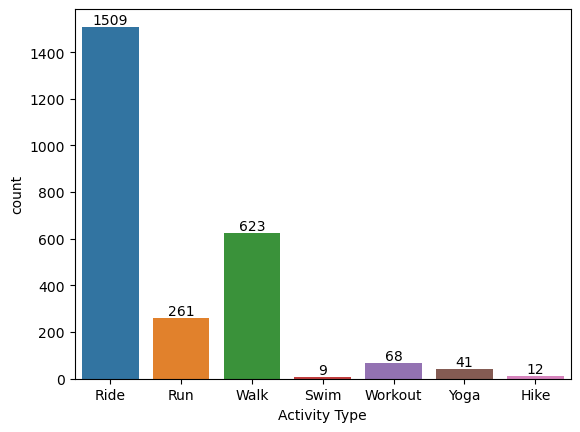

In [20]:
act_count = sns.countplot(data=strava,x="Activity Type") # generate a plot showing the number of activities of each type
act_count.bar_label(act_count.containers[0]) # add numerical values to the bars
plt.show()

What are the typical weather conditions for those activities with automatically recorded weather data?

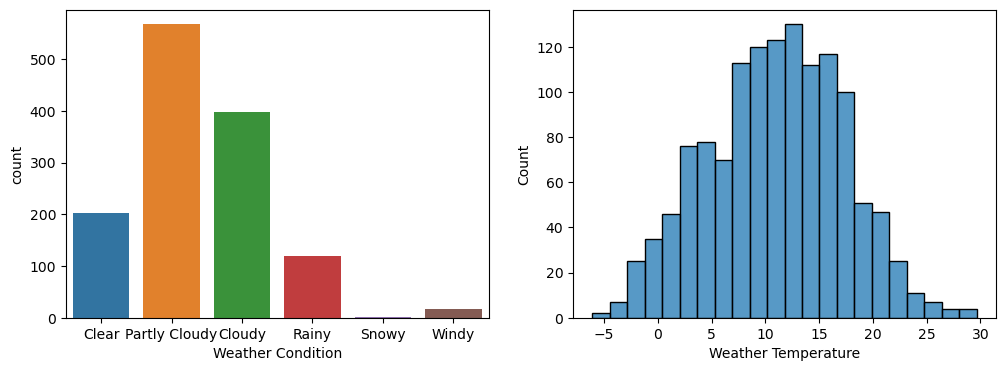

In [21]:
# generate a 1 x 2 subplot grid and specify the figure size
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# plot 1 shows the frequency of each type of weather condition
ax = sns.countplot(data=strava,x="Weather Condition",
                   order=["Clear","Partly Cloudy","Cloudy","Rainy","Snowy","Windy"],ax=axes[0])

# plot 2 shows the distribution of the observed temperatures across all activities with associated weather data
ax = sns.histplot(data=strava,x="Weather Temperature",ax=axes[1])

plt.show()

In [22]:
# calculate the mean temperature and report within an f-string
mean_temp = strava["Weather Temperature"].mean()
print(f"The mean temperature across all activities with weather data is {round(mean_temp,1)}°C.")

The mean temperature across all activities with weather data is 11.0°C.


How does the average speed of an activity differ dependent on the bike used?

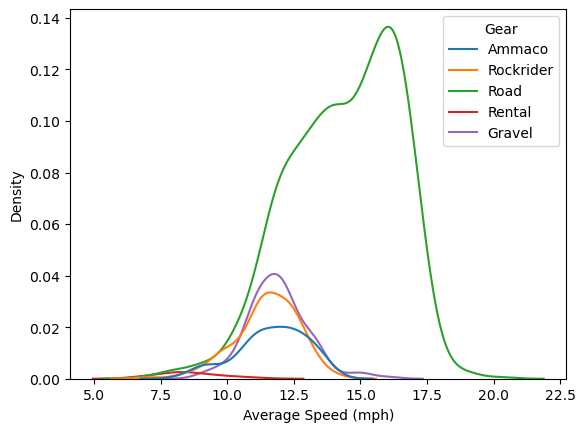

In [23]:
sns.kdeplot(data=strava_ride[(strava_ride["Average Speed (mph)"] > 1)],x="Average Speed (mph)",hue="Gear")
plt.show()

As the plot above shows, the fastest rides were done on my road bike while the average speed across the Rockrider, Ammaco and gravel bikes appear to be similar. I applied a filter to omit two anomalous rides that have a distance of 0 miles and therefore an average speed of 0 mph. 

## K-Nearest Neighbours Analysis of Cycle Commutes

Finally, I wish to explore k-nearest neighbours analysis of cycle commutes to probe if machine learning can determine the location of the commute based on chosen variables.

In [24]:
# create a ride commute data frame by filtering the rides-only data frame
ride_commute = pd.DataFrame(strava_ride[strava_ride["Commute"] == True]) 
ride_commute["Location"] = "" # add an empty column for commute location to be populated below

In [25]:
# create a separate data frame containing the start and end dates for each commute
data = [["QMC","04-07-16","26-08-16"],
        ["Sutton Bonington","29-08-17","31-05-18"],
        ["Milton Park","18-06-18","25-04-19"],
        ["Headington","14-10-19","10-05-22"],
        ["Bath","26-09-22","15-12-22"]]
location = pd.DataFrame(data,columns = ["Location", "Start Date", "End Date"])

# convert the date columns from objects to datetime format
location["Start Date"] = pd.to_datetime(location["Start Date"])
location["End Date"] = pd.to_datetime(location["End Date"])

# visualise the location data frame
location

,Location,Start Date,End Date
0,QMC,2016-04-07,2016-08-26
1,Sutton Bonington,2017-08-29,2018-05-31
2,Milton Park,2018-06-18,2019-04-25
3,Headington,2019-10-14,2022-10-05
4,Bath,2022-09-26,2022-12-15


In [26]:
# loop through the ride commute dataframe
for i, row in ride_commute.iterrows():
    # compare the activity date to the location dataframe 
    if location.loc[0,"Start Date"] <= row["Activity Date"] <= location.loc[0,"End Date"]: 
        # populate the 'location' in the ride commute data frame accordingly
        ride_commute.loc[i,"Location"] = location.loc[0,"Location"]
        
    elif location.loc[1,"Start Date"] <= row["Activity Date"] <= location.loc[1,"End Date"]:
        ride_commute.loc[i,"Location"] = location.loc[1,"Location"]
        
    elif location.loc[2,"Start Date"] <= row["Activity Date"] <= location.loc[2,"End Date"]:
        ride_commute.loc[i,"Location"] = location.loc[2,"Location"]
        
    # eg is the date between 14/10/19 and 10/05/22
    elif location.loc[3,"Start Date"] <= row["Activity Date"] <= location.loc[3,"End Date"]: 
         # update the location to 'Headington'
        ride_commute.loc[i,"Location"] = location.loc[3,"Location"]
        
    elif location.loc[4,"Start Date"] <= row["Activity Date"] <= location.loc[4,"End Date"]: 
        ride_commute.loc[i,"Location"] = location.loc[4,"Location"]

# visualise the final cycle commute data frame 
ride_commute

,Activity Date,Start Time,Activity Name,Activity Type,Commute,Gear,Elapsed Time (mins),Moving Time (mins),Distance (miles),Max Speed (mph),...,Average Heart Rate,Relative Effort,Elevation Gain (m),Max Elevation (m),Max Grade,Max Cadence,Average Cadence,Weather Condition,Weather Temperature,Location
38,2016-07-04,17:03:20,Ride_15,Ride,True,Ammaco,34.07,33.73,6.60,22.15,...,NaN,<NA>,31.85,66.2,11.900000,<NA>,NaN,NaN,NaN,QMC
39,2016-07-05,06:59:09,Ride_16,Ride,True,Ammaco,628.15,66.53,13.20,27.23,...,NaN,<NA>,95.58,60.2,11.281354,<NA>,NaN,NaN,NaN,QMC
40,2016-07-06,06:47:55,Ride_17,Ride,True,Ammaco,669.4,73.7,15.31,24.02,...,NaN,<NA>,65.43,60.2,11.311048,<NA>,NaN,NaN,NaN,QMC
41,2016-07-07,07:03:30,Ride_18,Ride,True,Ammaco,652.35,62.45,13.13,26.69,...,NaN,<NA>,96.24,60.2,27.473856,<NA>,NaN,NaN,NaN,QMC
42,2016-07-08,07:02:53,Ride_19,Ride,True,Ammaco,641.8,62.05,13.00,25.40,...,NaN,<NA>,94.32,60.2,11.184058,<NA>,NaN,NaN,NaN,QMC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,2022-12-07,08:09:57,Ride_1497,Ride,True,Gravel,732.32,54.75,10.38,29.90,...,NaN,36,196.36,179.4,27.303797,<NA>,NaN,Partly Cloudy,0.42,Bath
2490,2022-12-08,09:06:39,Ride_1498,Ride,True,Gravel,548.9,51.27,10.30,30.67,...,NaN,34,192.31,176.7,47.559547,<NA>,NaN,Partly Cloudy,-1.70,Bath
2491,2022-12-09,09:14:52,Ride_1499,Ride,True,Gravel,526.13,51.43,10.32,29.40,...,NaN,25,189.72,176.7,25.641121,<NA>,NaN,Partly Cloudy,-1.88,Bath
2503,2022-12-14,09:16:05,Ride_1502,Ride,True,Gravel,708.12,53.95,11.17,31.85,...,134.749695,46,218.40,180.7,22.569393,<NA>,NaN,Cloudy,-2.94,Bath


In order to carry out a K-nearest neighbours analysis it is best to have two independent variables that give a broad distribution of the data. Below is a scatter matrix showing the relationship between the continuous variables in the 'ride_commute' dataframe. Due to the repeated nature of commuting, many of the variables are rather stratified.

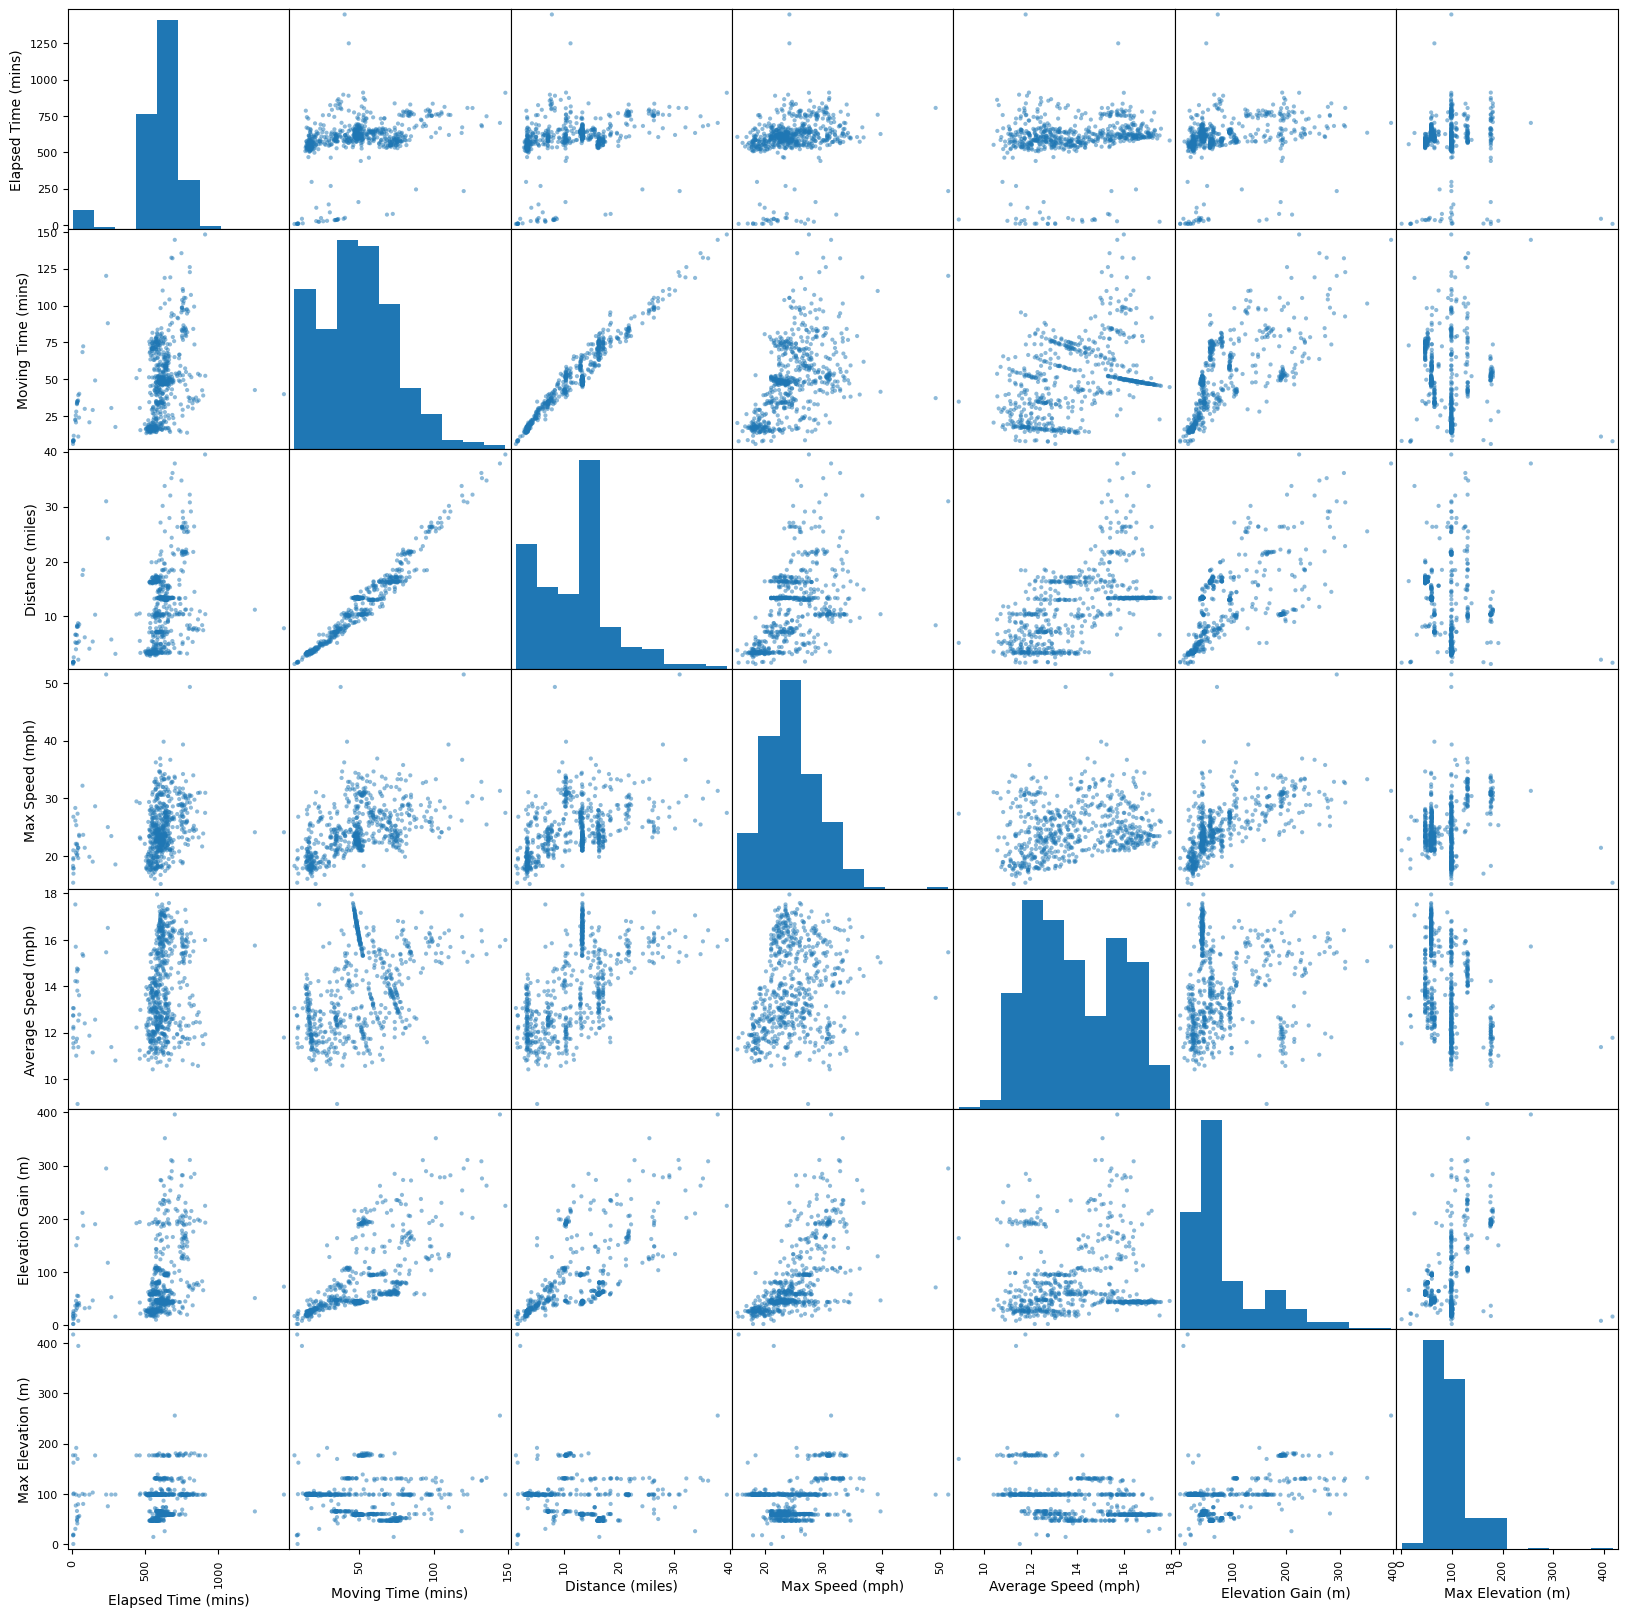

In [27]:
# create a list of the variables I wish to be included in the scatter matrix
# have omitted categorical/object variables
mtrx_lst = ['Elapsed Time (mins)',
 'Moving Time (mins)',
 'Distance (miles)',
 'Max Speed (mph)',
 'Average Speed (mph)',
  'Elevation Gain (m)',
 'Max Elevation (m)',
 ]

# visualise the matrix
matrix = pd.plotting.scatter_matrix(ride_commute[mtrx_lst], figsize = (20,20))

In [28]:
# define the colours I wish to use in the plots below (taken from the seaborn deep theme)
palette = {
    "QMC":"#4c72b0",
    "Sutton Bonington":"#dd8452",
    "Milton Park":"#55a868",
    "Headington":"#c44e52",
    "Bath":"#8172b3"
}

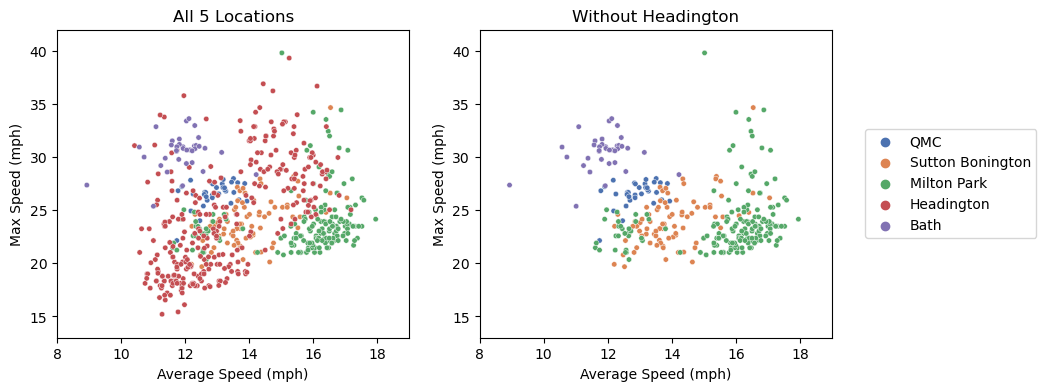

In [29]:
# create a 1 x 2 subplot grid and specify the figure size
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# plot 1 shows Average Speed against Max Speed
# I have filtered for Max Speed < 40 mph because any values above that are anomalous
ax1 = sns.scatterplot(data=ride_commute[(ride_commute["Max Speed (mph)"] < 40)],
                     x="Average Speed (mph)",
                     y="Max Speed (mph)",
                     hue="Location", # colour the data points based on the location of the commute
                     palette = palette, # using the colours stated in the palette dictionary above
                     s=15, # specify the size of the data points
                     ax=axes[0]) # state where in the subplot grid the scatterplot should be placed
ax1.set_xlim([8, 19]) # define the x-axis limits for plot 1
ax1.set_ylim([13, 42]) # define the y-axis limits for plot 2
ax1.title.set_text("All 5 Locations") # apply a title to plot 1 
ax1.legend(bbox_to_anchor = (2.8,0.5), loc='center right') # specify the location of the legend (which will apply to both plots)

# plot 2 is as above but having removed any commutes in Headington
ax2 = sns.scatterplot(data=ride_commute[(ride_commute["Location"] != "Headington") & (ride_commute["Max Speed (mph)"] < 40)],
                      x="Average Speed (mph)",
                     y="Max Speed (mph)",hue="Location",palette = palette,s=15,ax=axes[1])
ax2.set_xlim([8, 19])
ax2.set_ylim([13, 42])
ax2.title.set_text("Without Headington")
ax2.get_legend().remove() # don't show the legend for this plot

Based on the scatter matrix, the two variables with the broadest distribution appear to be average speed and max speed. There is far greater variability in the data across the data for Headington commutes shown in red. This is unsurprising given that I often varied my route to and from work much more than in other locations. The same plot having omitted the Headington data appears more appropriate for k-nearest neighbours analysis.

In [30]:
# define a function which will enable the visualisation of the k-nearest neighbours model
def plot_knn(model, X, y, resolution=100, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    if X.shape[1] != 2:
        raise ValueError(f"X must have exactly two features to plot, you passed X.shape={X.shape}")
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    x1 = X.iloc[:,0]
    x2 = X.iloc[:,1]
    x1_range = np.linspace(x1.min()*1.1 - x1.max()*0.1, x1.max()*1.1 - x1.min()*0.1, resolution)
    x2_range = np.linspace(x2.min()*1.1 - x2.max()*0.1, x2.max()*1.1 - x2.min()*0.1, resolution)
    grid_x1_values, grid_x2_values = np.meshgrid(x1_range, x2_range)
    x_prime = np.column_stack((grid_x1_values.ravel(), grid_x2_values.ravel()))
    x_prime = pd.DataFrame(x_prime, columns=X.columns)
    y_hat = model.predict(x_prime).reshape(grid_x1_values.shape)

    if ax is None:
        fig, ax = plt.subplots()
    ax.pcolormesh(grid_x1_values, grid_x2_values, y_hat, cmap="Pastel2", alpha=1.0, shading="auto")
    X.plot.scatter(0, 1, c=y, colormap="Dark2", colorbar=False, alpha=0.8, ax=ax)

In [31]:
# in order for the plot.scatter() 'c' argument to colour the data points by location, the variable must be numerical
# generate a dictionary to provide a numerical representation of each commute location
locations_knn = {
    "QMC":0,
    "Sutton Bonington":1,
    "Milton Park":2,
    "Headington":3,
    "Bath":4
}

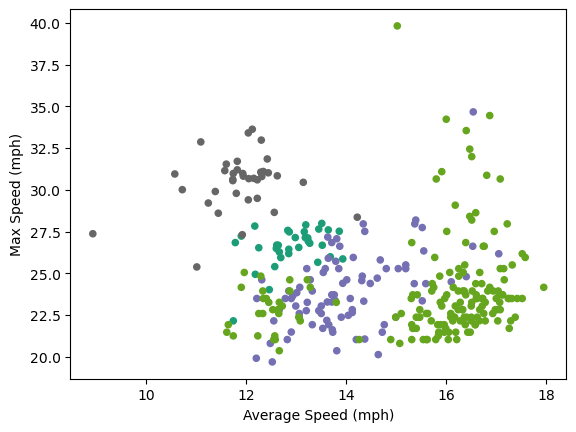

In [32]:
# create a smaller data frame that contains commutes but excludes 'Headington'
df = pd.DataFrame(ride_commute[ride_commute["Location"] != "Headington"])

# define the X variables for the nearest neighbours analysis
X1 = df[["Average Speed (mph)", "Max Speed (mph)"]]

# add a new column which contains the numerical representation of the commute location (as defined by the dictionary above)
df["Location_no"] = df['Location'].apply(lambda x: locations_knn.get(x, x))

# define the y variable for the nearest neighbours analysis
y1 = df["Location_no"]

# plot the two variables of interest 
X1.plot.scatter("Average Speed (mph)", "Max Speed (mph)", 
                c=y1, # colour the datapoints according to the 'location number' y variable
                colormap = "Dark2", colorbar=False)

# split the dataset into training and testing data for the k-nn model
train_X1, test_X1, train_y1, test_y1 = train_test_split(X1, y1, random_state = 20)

In [33]:
# state the range of k values you wish to assess
nbrs = {
    "n_neighbors" : range(1, 51),
}

# model each of the possible k values between 1-50  
commute_knn = GridSearchCV(KNeighborsClassifier(), nbrs)
commute_knn.fit(train_X1, train_y1)

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51)})

<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

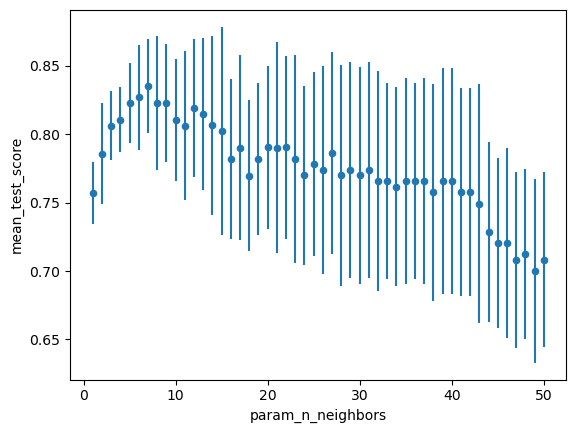

In [34]:
# save the data from the hyperparameter search in a data frame
commutecv_results = pd.DataFrame(commute_knn.cv_results_)

# visualise the test scores for each k value
commutecv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score")

With the random state specified as 20. The resulting optimum k value is 7. Therefore carry out the nearest neighbours analysis with k=7.

In [35]:
# generate the k-nn model using the optimum k value of 7 and the training data
commute_model = KNeighborsClassifier(n_neighbors=7)
commute_model.fit(train_X1, train_y1)

KNeighborsClassifier(n_neighbors=7)

In [36]:
# calculate the test score for this model using the test data
round(commute_model.score(test_X1, test_y1),2)

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.84

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


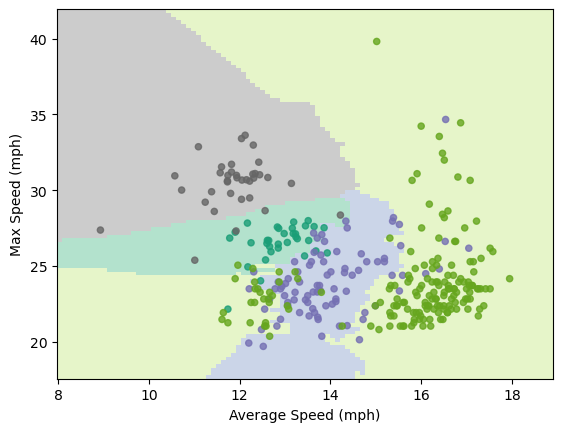

In [37]:
# use the function defined above to visualise this model
plot_knn(commute_model, X1, y1)

To provide a comparison, here is the same analysis repeated having included the Headington commute data. 

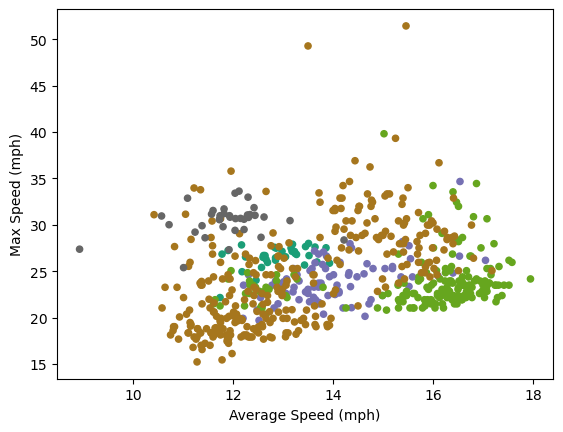

In [38]:
X2 = ride_commute[["Average Speed (mph)", "Max Speed (mph)"]]
ride_commute["Location_no"] = ride_commute['Location'].apply(lambda x: locations_knn.get(x, x))
y2 = ride_commute["Location_no"]

X2.plot.scatter("Average Speed (mph)", "Max Speed (mph)", c=y2, colormap = "Dark2", colorbar=False)

train_X2, test_X2, train_y2, test_y2 = train_test_split(X2, y2, random_state = 20)

In [39]:
commute_model_headington = KNeighborsClassifier(n_neighbors=7)
commute_model_headington.fit(train_X2, train_y2)

KNeighborsClassifier(n_neighbors=7)

In [40]:
round(commute_model_headington.score(test_X2, test_y2),2)

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.71

As can be seen, including the Headington data and using the same parameters gives a poorer model score. This is visualised in the plot below. 

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


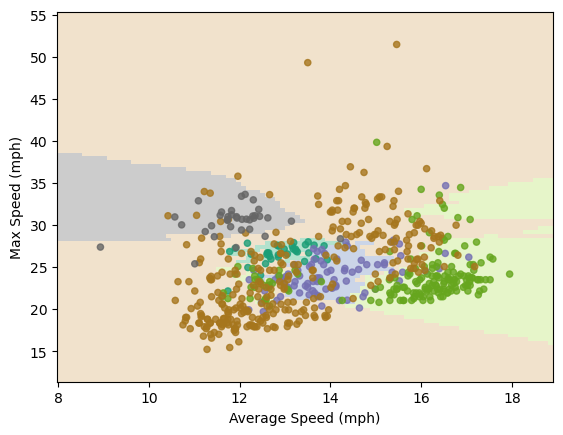

In [41]:
plot_knn(commute_model_headington, X2, y2)

## Report Figures

The code below generates the same plots seen above but rearranges them for use in the associated report.

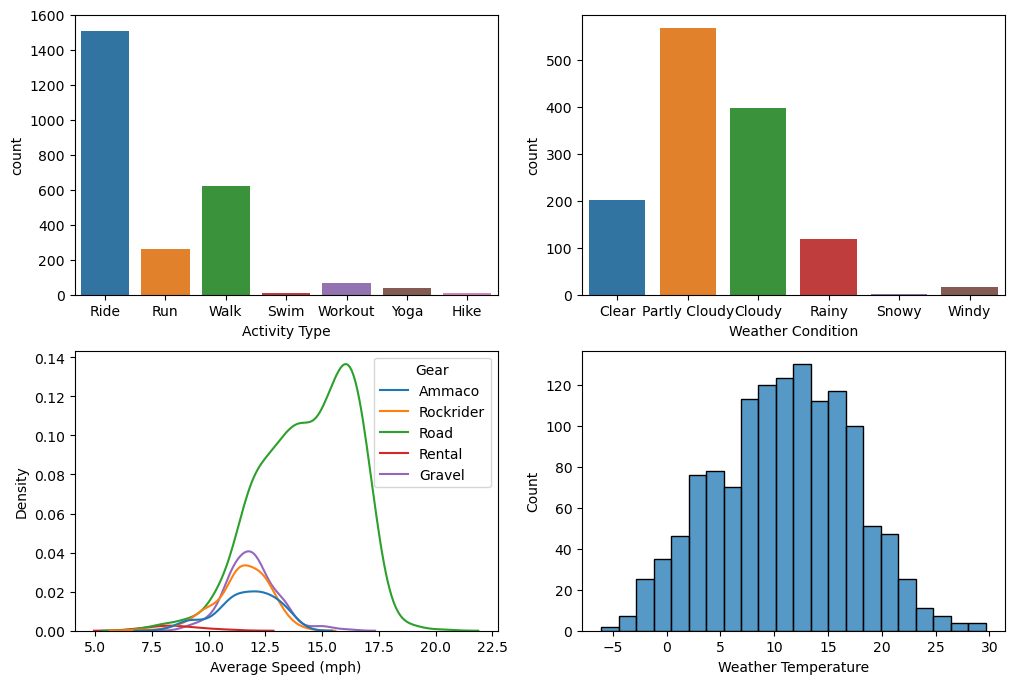

In [42]:
# generate a 2 x 2 subplot grid for all 4 plots generated in the 'visualisation' section 
fig, axes = plt.subplots(2, 2, figsize=(12,8))

ax1 = sns.countplot(data=strava,x="Activity Type", ax=axes[0,0])
ax1.set_ylim([0, 1600])
ax2 = sns.countplot(data=strava,x="Weather Condition",
                   order=["Clear","Partly Cloudy","Cloudy","Rainy","Snowy","Windy"],ax=axes[0,1])
ax3 = sns.histplot(data=strava,x="Weather Temperature",ax=axes[1,1])
ax4 = sns.kdeplot(data=strava_ride[(strava_ride["Average Speed (mph)"] > 1)],x="Average Speed (mph)",hue="Gear",ax=axes[1,0])
plt.show()

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

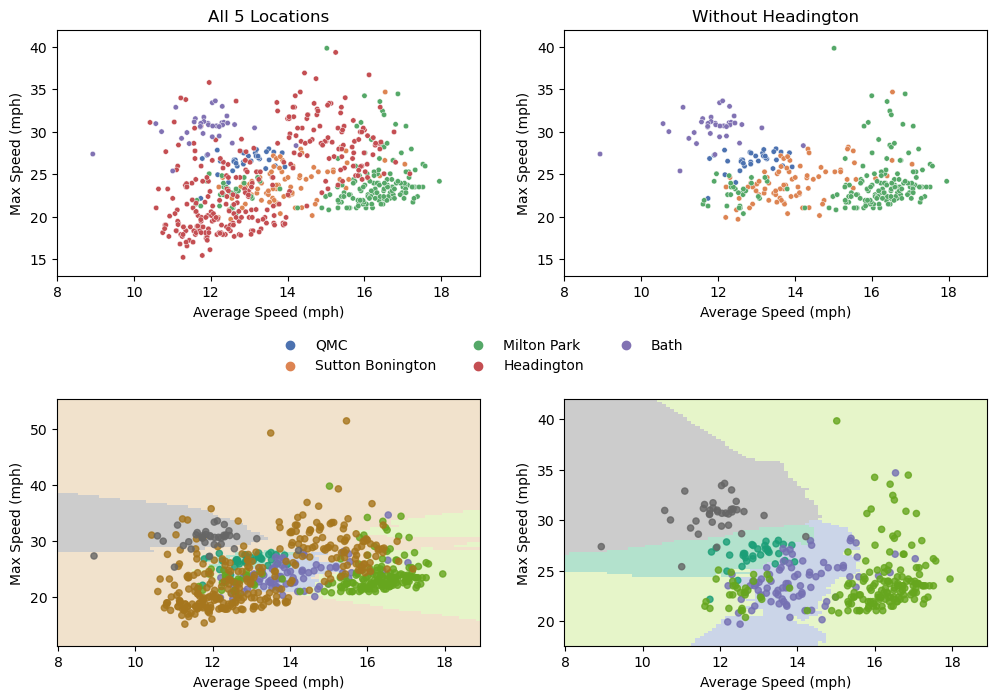

In [43]:
# generate a 2 x 2 subplot grid for the scatter plots and k-nn outputs for the commute date,
# with and without Headington
fig, axes = plt.subplots(2, 2, figsize=(12,8))
ax1 = sns.scatterplot(data=ride_commute[(ride_commute["Max Speed (mph)"] < 40)],
                     x="Average Speed (mph)",
                     y="Max Speed (mph)",hue="Location",palette = palette,s=15,ax=axes[0,0])
ax1.set_xlim([8, 19])
ax1.set_ylim([13, 42])
ax1.title.set_text("All 5 Locations")
# modified the location of the legend to be more space efficient
ax1.legend(bbox_to_anchor = (1,-0.2), loc='upper center',ncol=3,frameon=False)  

ax2 = sns.scatterplot(data=ride_commute[(ride_commute["Location"] != "Headington") & (ride_commute["Max Speed (mph)"] < 40)],
                      x="Average Speed (mph)",
                     y="Max Speed (mph)",hue="Location",palette = palette,s=15,ax=axes[0,1])
ax2.set_xlim([8, 19])
ax2.set_ylim([13, 42])
ax2.title.set_text("Without Headington")
ax2.get_legend().remove()
ax3 = plot_knn(commute_model, X1, y1,ax=axes[1,1])
ax4 = plot_knn(commute_model_headington, X2, y2,ax=axes[1,0])
plt.subplots_adjust(hspace = 0.5) # add more space between the plots to make room for the legend
plt.show()